# Importação das Bibliotecas
As bibliotecas que serão utilizadas `pandas` e `matplotlib` necessitam ser importadas.

In [201]:
import pandas as pd
import matplotlib.pyplot as plt

# Leitura do arquivo googleplaystore.csv
Para realizar a leitura, a biblioteca `pandas` traz a função `read_csv()` capaz de realizar a leitura.

Identifiquei assim o separador utilizado, o símbolo para decimais e para os "milhares".

In [235]:
filename = 'googleplaystore.csv'
df = pd.read_csv(filename, sep=",", decimal=".", thousands=",")

# 1 - Tratamento de Dados
Utilização da função `info()`: identifiquei o total de entradas e o total de colunas (10841 e 13, respectivamente), além dos tipos de cada coluna. 

In [203]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


## 1.1 - Correção de tipos de dados incorretos
Com isso, percebi que algumas colunas estão com os tipos inconsistentes.
São elas:
- *Reviews*
- *Size*
- *Installs*
- *Price*
- *Last Updated*

### 1.1.1 - Coluna *Reviews*
Ela é do tipo `string`, porém *reviews* é uma informação numérica, podendo ser convertida para o tipo `int`. 

In [236]:
# tentar identificar o motivo de ser string
nonNumericReviews = df.loc[pd.to_numeric(df['Reviews'], errors='coerce').isna()]

print(nonNumericReviews)

                                           App Category  Rating Reviews  \
10472  Life Made WI-Fi Touchscreen Photo Frame      1.9    19.0    3.0M   

         Size Installs Type     Price Content Rating             Genres  \
10472  1,000+     Free    0  Everyone            NaN  February 11, 2018   

      Last Updated Current Ver Android Ver  
10472       1.0.19  4.0 and up         NaN  


Problema na linha 10472: não possui campo *Category*.

Percebe-se que todos os campos após categoria estão alterados devido à ausência dela. Eles foram trazidos para a esquerda. Vamos corrigir isso.

In [237]:
# ajuste da linha 10472
df.loc[10472] = {
    'App': 'Life Made WI-Fi Touchscreen Photo Frame',
    'Category': "",
    'Rating': 1.9,
    'Reviews': '19',
    'Size': '19.0M',
    'Installs': '1,000+',
    'Type': 'Free',
    'Price': 0,
    'Content Rating': 'Everyone',
    'Genres': "",
    'Last Updated': 'February 11, 2018',
    'Current Ver': '1.0.19',
    'Android Ver': '4.0 and up'
}

Agora, podemos transformar o campo "Reviews" em integer normalmente.

In [238]:
df['Reviews'] = df['Reviews'].astype('Int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  Int64  
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10841 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10839 non-null  object 
dtypes: Int64(1), float64(1), object(11)
memory usage: 1.1+ MB


### 1.1.2 - Coluna *Size* 
É do tipo `string`, porém a informação pode ser convertida para `float`.

In [207]:
# Entendendo o motivo de ser string
df.groupby(['Size']).size()

Size
1.0M                     7
1.1M                    32
1.2M                    41
1.3M                    35
1.4M                    37
                      ... 
98M                     16
992k                     1
994k                     1
99M                     39
Varies with device    1695
Length: 462, dtype: int64

Essa coluna é do tipo `string`, pois possui, ao lado do valor numérico, um M (de megabytes), k (de kilobytes) e alguns valores são "*Varies with device*".

Devemos tratar isso

In [239]:
# tratamento de size
def convert_size(size):
    if isinstance(size, str):
            size = size.strip().upper()
            if size.endswith('M'):
                return float(size.replace('M', ''))
            elif size.endswith('K'):
                return float(size.replace('K', '')) / 1024
            elif size == 'VARIES WITH DEVICE':
                return None
            else:
                return None
    return None

df['Size'] = df['Size'].apply(convert_size)

In [240]:
# Agora os dados estão todos em megabytes e são do tipo float
df.groupby(['Size']).size()

Size
0.008301       1
0.010742       1
0.013672       1
0.016602       2
0.017578       2
              ..
96.000000     26
97.000000     20
98.000000     16
99.000000     39
100.000000    16
Length: 459, dtype: int64

Com isso, há vários registros de "tamanho" com valor nulo. Esses deverão ser desconsiderados para não viesar a análise.

Além disso, agora todos os dados estão em megabytes.

### 1.1.3 - Coluna *Installs*
É do tipo `string`, mas deveria ser `int`.

In [241]:
# investigando o motivo
df.groupby(['Installs']).size()

Installs
0                    1
0+                  14
1+                  67
1,000+             908
1,000,000+        1579
1,000,000,000+      58
10+                386
10,000+           1054
10,000,000+       1252
100+               719
100,000+          1169
100,000,000+       409
5+                  82
5,000+             477
5,000,000+         752
50+                205
50,000+            479
50,000,000+        289
500+               330
500,000+           539
500,000,000+        72
dtype: int64

O motivo de ser string consiste na presença de caracteres como a vírgula ',' e o '+'. Devemos removê-los e converter para int.

In [242]:
df['Installs'] = df['Installs'].replace('[\+,]', '', regex=True).astype('Int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  Int64  
 4   Size            9146 non-null   float64
 5   Installs        10841 non-null  Int64  
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10841 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10839 non-null  object 
dtypes: Int64(2), float64(2), object(9)
memory usage: 1.1+ MB


### 1.1.4 - Coluna *Price*
É do tipo `string`, porém esse tipo de dado deve ser numérico.

In [243]:
# analisando o motivo de ser string
df.groupby(['Price']).size()

Price
0             1
$0.99       148
$1.00         3
$1.04         1
$1.20         1
          ...  
$8.99         5
$89.99        1
$9.00         2
$9.99        21
0         10040
Length: 93, dtype: int64

Percebe-se que há muitos registros com o valor 0 (apps gratuitos), e todos os outros possuem o '$' antes do valor, o que torna isso uma string para o Python. Devemos tratar isso.

In [244]:
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype('Float64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  Int64  
 4   Size            9146 non-null   float64
 5   Installs        10841 non-null  Int64  
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  Float64
 8   Content Rating  10841 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10839 non-null  object 
dtypes: Float64(1), Int64(2), float64(2), object(8)
memory usage: 1.1+ MB


### 1.1.5 - Coluna *Last Updated*
É do tipo `string`, mas deveria ser do tipo `date`. 

In [245]:
# investigando o motivo de ser string
df.groupby(['Last Updated']).size()

Last Updated
April 1, 2016        4
April 1, 2017        4
April 1, 2018        5
April 10, 2013       1
April 10, 2014       1
                    ..
September 8, 2016    2
September 8, 2017    5
September 9, 2015    1
September 9, 2016    2
September 9, 2017    1
Length: 1377, dtype: int64

Percebe-se a presença de vírgulas. Deve-se formatar e converter para o tipo `date`.

In [246]:
# conversão para date
df['Last Updated'] = pd.to_datetime(df['Last Updated'], format='%B %d, %Y')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   App             10841 non-null  object        
 1   Category        10841 non-null  object        
 2   Rating          9367 non-null   float64       
 3   Reviews         10841 non-null  Int64         
 4   Size            9146 non-null   float64       
 5   Installs        10841 non-null  Int64         
 6   Type            10840 non-null  object        
 7   Price           10841 non-null  Float64       
 8   Content Rating  10841 non-null  object        
 9   Genres          10841 non-null  object        
 10  Last Updated    10841 non-null  datetime64[ns]
 11  Current Ver     10833 non-null  object        
 12  Android Ver     10839 non-null  object        
dtypes: Float64(1), Int64(2), datetime64[ns](1), float64(2), object(7)
memory usage: 1.1+ MB


## 1.2 Identificar dados *missing*

Agora, verificarei se há algum valor nulo no conjunto de dados.

In [247]:
df.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size              1695
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

Percebe-se que 1474 registros possuem "*Rating*" nulo, 1695 possuem "*Size*" nulo, 1 possui "*Type*" nulo, 8 possuem "*Current Ver*" nulo e 2 possuem "*Android Ver*" nulos.

### 1.2.1 - Tratamento de "*Rating*" nulo

In [248]:
# entendendo o que há nesse registro
df.loc[df['Rating'].isnull()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
23,Mcqueen Coloring pages,ART_AND_DESIGN,NaN,61,7.0,100000,Free,0.0,Everyone,Art & Design;Action & Adventure,2018-03-07,1.0.0,4.1 and up
113,Wrinkles and rejuvenation,BEAUTY,NaN,182,5.7,100000,Free,0.0,Everyone 10+,Beauty,2017-09-20,8.0,3.0 and up
123,Manicure - nail design,BEAUTY,NaN,119,3.7,50000,Free,0.0,Everyone,Beauty,2018-07-23,1.3,4.1 and up
126,Skin Care and Natural Beauty,BEAUTY,NaN,654,7.4,100000,Free,0.0,Teen,Beauty,2018-07-17,1.15,4.1 and up
129,"Secrets of beauty, youth and health",BEAUTY,NaN,77,2.9,10000,Free,0.0,Mature 17+,Beauty,2017-08-08,2.0,2.3 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10824,Cardio-FR,MEDICAL,NaN,67,82.0,10000,Free,0.0,Everyone,Medical,2018-07-31,2.2.2,4.4 and up
10825,Naruto & Boruto FR,SOCIAL,NaN,7,7.7,100,Free,0.0,Teen,Social,2018-02-02,1.0,4.0 and up
10831,payermonstationnement.fr,MAPS_AND_NAVIGATION,NaN,38,9.8,5000,Free,0.0,Everyone,Maps & Navigation,2018-06-13,2.0.148.0,4.0 and up
10835,FR Forms,BUSINESS,NaN,0,9.6,10,Free,0.0,Everyone,Business,2016-09-29,1.1.5,4.0 and up


Denota-se que não há o que ser feito, não há um valor que possa ocupar o lugar do nulo nos campos *Rating* nulos. Por isso, eles serão desconsiderados para a análise.

### 1.2.2 - Tratamento de "*Size*" nulo
Nesse caso, optou-se por deixar nulos vários registros, os quais continham (*Varies with device*). Isso foi feito para poder converter *Size* para float.

### 1.2.3 Tratamento de "*Type*" nulo

In [249]:
# entendendo o que há nesse registro
df.loc[df['Type'].isnull()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
9148,Command & Conquer: Rivals,FAMILY,NaN,0,NaN,0,NaN,0.0,Everyone 10+,Strategy,2018-06-28,Varies with device,Varies with device


Percebe-se que o preço é 0. Portanto, o tipo dele deve ser "Free"

In [250]:
df['Type'] = df['Price'].apply(lambda x: 'Free' if x == 0.0 else 'Paid')

In [251]:
df.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size              1695
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

Não há mais registro com tipo nulo. Solucionado.

### 1.2.4 - "*Current Ver*" e "*Android Ver*" nulos
Não necessitam ser tratados, pois não influenciarão na análise em questão.

## 1.3 - Eliminar duplicados

Para remover os duplicados, basta utilizar o método `drop_duplicates()`, também da biblioteca `pandas`.

In [253]:
df = df.sort_values(by='Reviews', ascending=False)

# Remover duplicatas baseando-se na coluna 'App', mantendo a linha com a data de atualização mais recente
dfNoDup = df.drop_duplicates(subset='App', keep='first')

# Resetar o índice (opcional, mas recomendado para melhor visualização)
df = df.reset_index(drop=True)

dfNoDup.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9660 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   App             9660 non-null   object        
 1   Category        9660 non-null   object        
 2   Rating          8197 non-null   float64       
 3   Reviews         9660 non-null   Int64         
 4   Size            8432 non-null   float64       
 5   Installs        9660 non-null   Int64         
 6   Type            9660 non-null   object        
 7   Price           9660 non-null   Float64       
 8   Content Rating  9660 non-null   object        
 9   Genres          9660 non-null   object        
 10  Last Updated    9660 non-null   datetime64[ns]
 11  Current Ver     9652 non-null   object        
 12  Android Ver     9658 non-null   object        
dtypes: Float64(1), Int64(2), datetime64[ns](1), float64(2), object(7)
memory usage: 1.1+ MB


Optei por realizar a eliminação de dados repetidos utilizando como parâmetro o número de Reviews.

A ideia inicial foi utilizar a data do último Update, porém havia registros iguais com a mesma data de update, porém com reviews diferentes. Sendo assim, aquele que possui mais reviews, é o mais próximo da atualidade, haja vista que elas só aumentam.

# 2 - Gráfico de barras com os top 5 *apps* por número de instalação
Utilizar a biblioteca `matplotlib`.

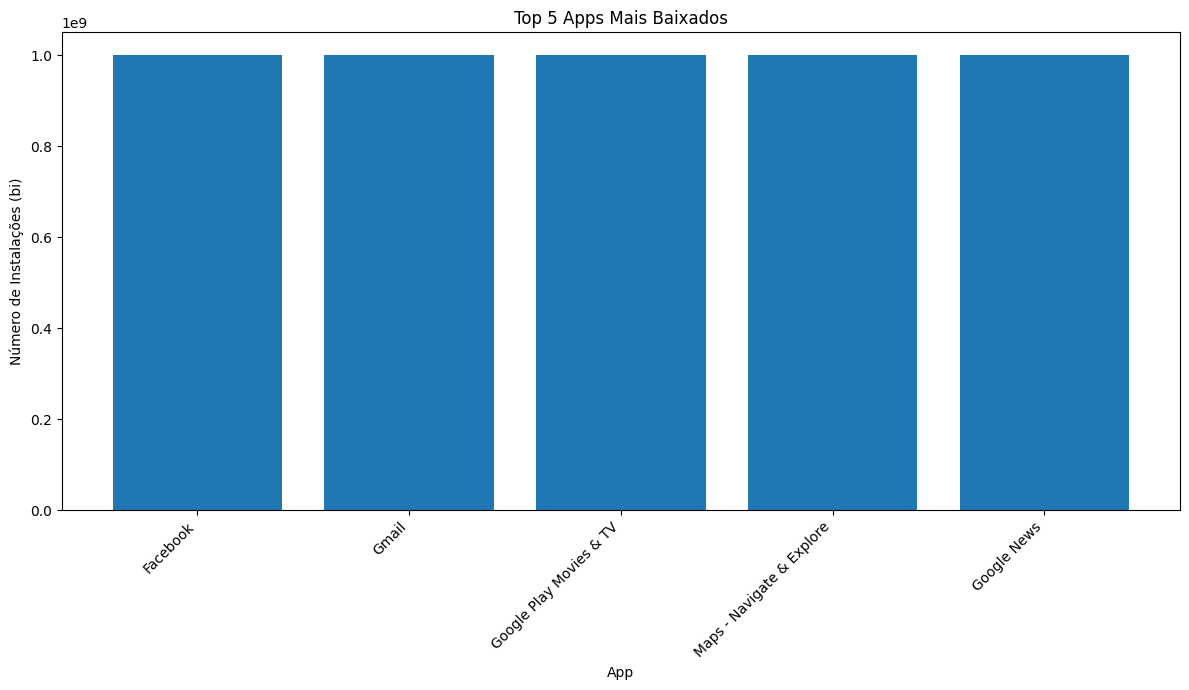

In [254]:
top_5_apps = dfNoDup.sort_values(by='Installs', ascending=False).head(5)

#print(top_5_apps)

plt.figure(figsize=(12, 7))
plt.bar(top_5_apps['App'], top_5_apps['Installs'])
plt.xlabel('App')
plt.ylabel('Número de Instalações (bi)')
plt.title('Top 5 Apps Mais Baixados')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar o gráfico
plt.show()


# 3 - Gráfico de pizza com categorias de apps
1. Contar quantos registros têm.
2. Contar quantos registros de cada categoria têm.
3. Plotar gráfico.
4. Há muitas categorias, gráfico está ficando confusa => criar categoria "OUTRAS" para aquelas com menos de 3%

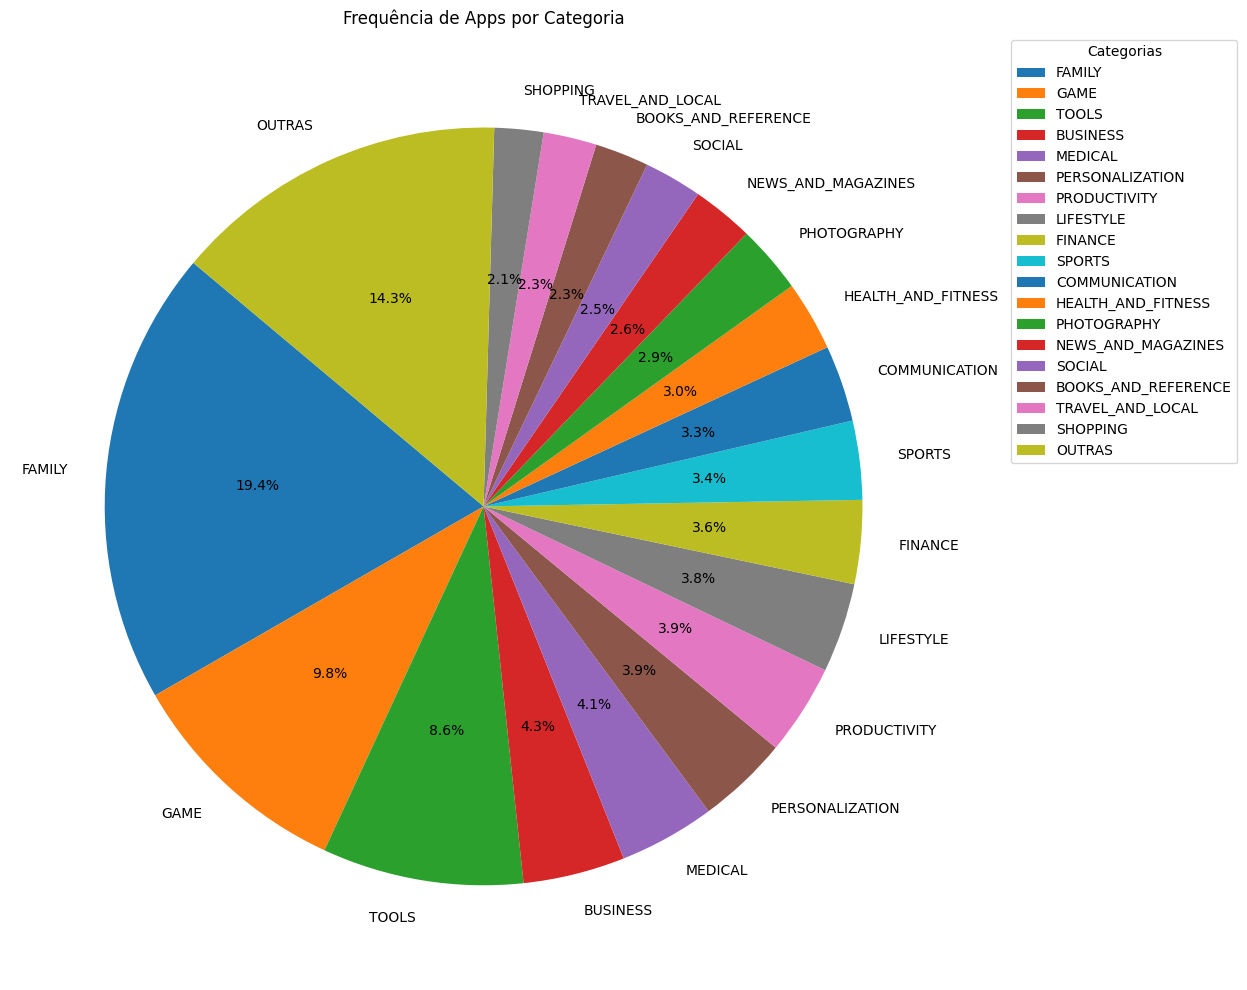

In [255]:
categoryCounts = dfNoDup['Category'].value_counts()

categoryPercentages = (categoryCounts / categoryCounts.sum()) * 100

categoriesLess2 = categoryPercentages[categoryPercentages < 2].index

categoryCounts['OUTRAS'] = categoryCounts[categoriesLess2].sum()
categoryCounts = categoryCounts[~categoryCounts.index.isin(categoriesLess2)]

plt.figure(figsize=(15, 10))

colors = plt.cm.Paired(range(len(categoryCounts)))

plt.pie(categoryCounts, labels=categoryCounts.index, autopct='%1.1f%%', startangle=140)

plt.legend(title="Categorias", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Frequência de Apps por Categoria')

plt.tight_layout()

plt.show()

# 4 - App mais caro do dataset

In [256]:
mostExpensiveIndex = dfNoDup['Price'].idxmax()

mostExpensiveApp = dfNoDup.loc[mostExpensiveIndex]

print(f"{mostExpensiveApp['App']} - ${mostExpensiveApp['Price']}")

I'm Rich - Trump Edition - $400.0


# 5 - Quantidade de Apps classificados como 'Mature 17+'

In [258]:
count = 0
for x in dfNoDup.index:
    if dfNoDup.loc[x, 'Content Rating'] == 'Mature 17+':
        count += 1

print(f"Quantidade de apps 'Mature +17': {count}")

Quantidade de apps 'Mature +17': 393


# 6 - Top 10 apps por número de reviews

In [259]:
mostReviews = dfNoDup.sort_values(by='Reviews', ascending=False).head(10)

count = 0
for index, row in mostReviews.iterrows():
    count += 1
    print(f"{count} - {row['App']} - {row['Reviews']}")

1 - Facebook - 78158306
2 - WhatsApp Messenger - 69119316
3 - Instagram - 66577446
4 - Messenger – Text and Video Chat for Free - 56646578
5 - Clash of Clans - 44893888
6 - Clean Master- Space Cleaner & Antivirus - 42916526
7 - Subway Surfers - 27725352
8 - YouTube - 25655305
9 - Security Master - Antivirus, VPN, AppLock, Booster - 24900999
10 - Clash Royale - 23136735


# 7 - Criação de dois cálculos sobre o dataset
### 7.1 - Lista: Top 10 apps com atualização mais recente

In [260]:
lastUpdated10 = dfNoDup.sort_values(by='Last Updated', ascending=False).head(10)
count = 0
for index, row in lastUpdated10.iterrows():
    count += 1
    print(f"{count}. {row['App']} - {row['Last Updated'].strftime('%d/%m/%Y')}")

1. Video Downloader For FB: Save FB Videos 2018 - 08/08/2018
2. BankNordik - 08/08/2018
3. Shoot Hunter-Gun Killer - 08/08/2018
4. Lalafo Pulsuz Elanlar - 08/08/2018
5. Fast Tract Diet - 08/08/2018
6. Bihar Land Records - RoR and EB Quick Pay - 07/08/2018
7. Propertyfinder - 07/08/2018
8. Bubble Bird Rescue - 07/08/2018
9. Scoreboard FR - 07/08/2018
10. [EF]ShoutBox - 07/08/2018


### 7.2 - Valor: App com mais instalações da categoria GAMES

In [261]:
games_df = dfNoDup[dfNoDup['Category'] == 'GAME']

most_installed_index = games_df['Installs'].idxmax()

most_installed_game = games_df.loc[most_installed_index]

print(f"Jogo com maior número de instalações:")
print(f"{most_installed_game['App']} - {most_installed_game['Installs']}+")

Jogo com maior número de instalações:
Subway Surfers - 1000000000+


# 8 - Criação de outras duas formas gráficas de exibição

### 8.1 - Relação entre *downloads* e data de atualização

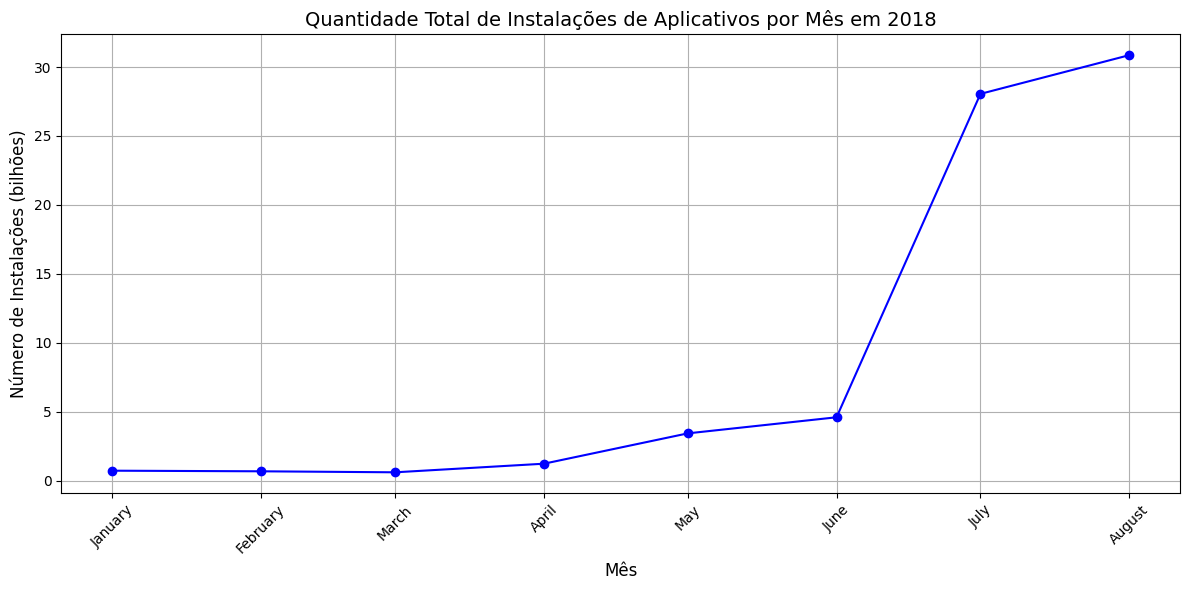

In [300]:
dfApps2018 = dfNoDup[dfNoDup['Last Updated'].dt.year == 2018]

# soma de instalações por mês
monthly_installs = dfApps2018.groupby(dfApps2018['Last Updated'].dt.to_period('M'))['Installs'].sum()

all_months = pd.period_range(start='2018-01', end='2018-08', freq='M')
all_months_df = pd.DataFrame(index=all_months, data={'Installs': 0})

monthly_installs_df = pd.DataFrame(monthly_installs).rename(columns={'Installs': 'Installs'})
all_months_df.update(monthly_installs_df)

# conversão para a casa dos bilhões
all_months_df['Installs'] = all_months_df['Installs'] / 1e9

plt.figure(figsize=(12, 6))
plt.plot(all_months_df.index.to_timestamp(), all_months_df['Installs'], marker='o', linestyle='-', color='b')

# formatação do gráfico
plt.title('Quantidade Total de Instalações de Aplicativos por Mês em 2018', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Número de Instalações (bilhões)', fontsize=12)
plt.grid(True)

months_labels = all_months_df.index.to_timestamp().strftime('%B')
plt.xticks(ticks=all_months_df.index.to_timestamp(), labels=months_labels, rotation=45)

plt.tight_layout()
plt.show()

Por meio desse gráfico, percebe-se que os aplicativos com data de atualização mais recentes também possuem maior número de instalações.

Manter um app atualizado é sempre um diferencial. 

### 8.2 - Gráfico de Dispersão (Avaliações X *Reviews*)

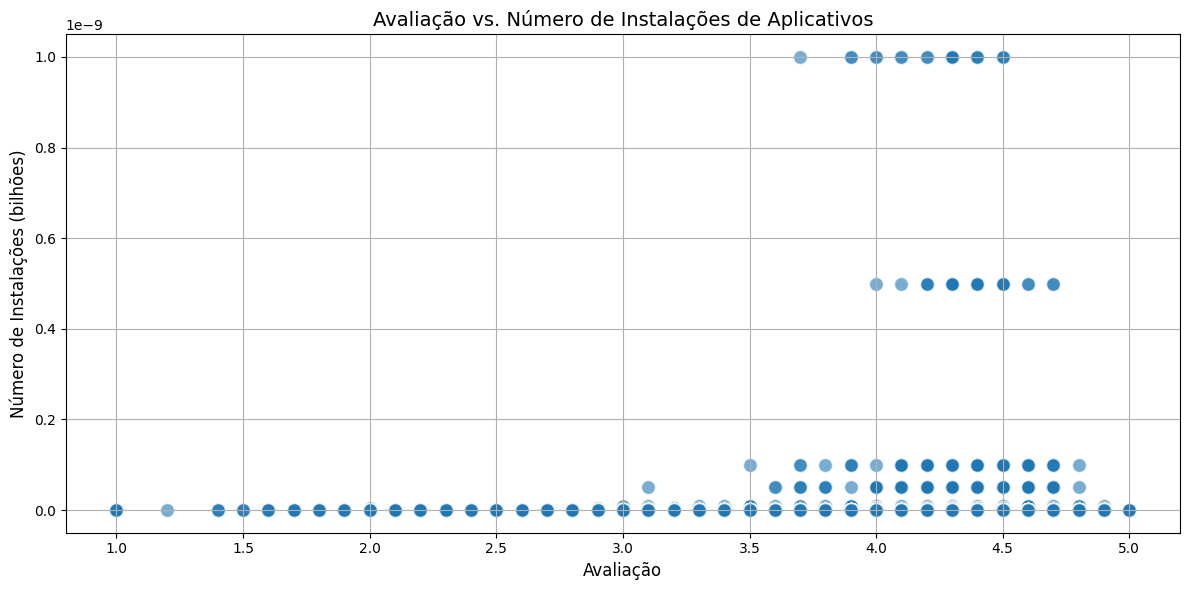

In [302]:
dfNoDup['Installs'] = dfNoDup['Installs'] / 1e9  # Convertendo para bilhões

# Criar o gráfico de dispersão
plt.figure(figsize=(12, 6))
plt.scatter(dfNoDup['Rating'], dfNoDup['Installs'], alpha=0.6, edgecolors='w', s=100)

# Melhorar a formatação do gráfico
plt.title('Avaliação vs. Número de Instalações de Aplicativos', fontsize=14)
plt.xlabel('Avaliação', fontsize=12)
plt.ylabel('Número de Instalações (bilhões)', fontsize=12)
plt.grid(True)

# Mostrar o gráfico
plt.tight_layout()
plt.show()